# Optimization Methods in Machine Learning

## Homework 3

For code-writing part of homework, please submit the single Jupyter Notebook file, where only Python and Markdown/LaTeX are used. The submission should be in the following format: *YourName_HW3.ipynb*.

You are free to modify the function templates and use additional libraries. However, do not use built-in functions if the assignment requires you to implement the method from scratch. Do not forget to add necessary explanations and comments.


The works will be checked for plagiarism. The score will be divided by the number of similar works.

### Problem 1 (8 pts)

Consider the empirical risk minimization problem with reguralizer:

\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}

where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ ($y$ must take only 2 values $0$ or $1$).
As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
$$
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
$$
where $b$ is the batch size, $s$ is the number of batches, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}+\lambda w.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

We will work with [mushrooms dataset](https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset/data).


In [51]:
!pip install kagglehub

In [52]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("prishasawhney/mushroom-dataset")

data = pd.read_csv(f"{path}/mushroom_cleaned.csv")

(1 pts) Implement the ability to uniformly divide the training part of the dataset into batches of size $b$ ($b$ is a parameter).

In [53]:
#your code
def split_data(b: int, shuffle: bool = False, data: pd.core.frame.DataFrame = data) -> tuple:
    '''
    Parameters:
    b: Batchsizes of each data
    data: Pandas Data Frame to be divided into batches

    Returns:
    out: tuple of pandas frame of a batch size b
    '''
    # 54035 = 5*101*107
    shuffled_data = data

    if shuffle:
        # Shuffle the rows of the dataframe
        shuffled_data = data.sample(frac = 1.0)

    out = []
    for i in range(0, len(data), b):
        out.append(shuffled_data[i: i+b])
    return tuple(out)

In [54]:
# testing the function
split_data(101)[0]

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1
...,...,...,...,...,...,...,...,...,...
96,731,6,2,10,0.481032,1319,11,0.943195,1
97,639,4,2,10,0.616318,1509,11,0.943195,1
98,725,4,2,10,1.368347,1747,11,0.943195,1
99,869,4,2,10,1.181334,1828,11,0.888450,1


(1 pts) Implement the SGD method:
$$
w^{k+1} = w^k - \gamma_k \nabla f_{j_k} (w^k),
$$
where the number $j_k$ is generated independently and uniformly from $\{1, \ldots, s \}$. For the tasks below, you may need to be able to measure the running time of the method.

In [55]:
#your code
import numpy as np
import time
import random
from tqdm import tqdm

def split_x_y(df):
    '''
    Splits the dataframe into features and target labels

    Parameters:
    df: pandas dataframe

    Returns:
    out: tuple of numpy arrays
    '''
    x = df[['cap-diameter', 'cap-shape', 'gill-attachment', 'gill-color',
            'stem-height', 'stem-width', 'stem-color', 'season']]
    x = x.to_numpy()
    y = df[['class']]
    y = y.to_numpy()
    return x, y

# default value for regularizer
regularizer = 0.25
def cost(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    for i in range(n):
        g = np.sum(w.T @ x[i])
        l = np.log(1 + np.exp(-np.sum(y[i])*g))
        loss += l

    loss /= n
    loss += regularizer * np.sum(w.T @ w)
    return loss

def gradient(w, x, y, regularizer = regularizer):
    '''
    Evaluates the gradient function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    grad: the value of the gradient function of a data batch for a given set of weights
    '''
    # batch size
    b = len(y)

    grad = np.zeros_like(x[0])
    for i in range(b):
        denominator = 1 + np.exp(np.sum(y[i] * (w.T @ x[i])))
        numerator = - np.sum(y[i]) * x[i]
        grad += numerator / denominator

    grad += regularizer * w
    return grad

def stochastic_gradient_descent(nabla_f, w_0, gamma_k, b,
                                K = 100, eps = 1e-6, tune_step = False):
    '''
    Minimizes the nabla_f using the stochastic gradient descent algorithm

    Parameters
    nabla_f:   the gradient of the cost function for a given sample
    w_0:       starting point
    gamma_k:   method step
    b:         batch size
    K:         number of iterations
    eps:       accuracy
    tune_step: boolean to turn on tune step or not

    Return
    w_opt: the point at which the minimum is reached
    err:   error vector, err = [convergence_criterion(x_1), \dots, convergence_criterion(x_K)]
    '''
    start = time.time()
    w_1 = w_0
    err = []
    batches = split_data(b)
    s = len(batches)
    batch = batches[random.randint(0, s-1)]
    x, y = split_x_y(batch)
    grad_0 = nabla_f(w_0, x, y)
    
    for k in tqdm(range(K)): # Number of iterations
        # generate j_k independently and uniformly from {1, 2, ..., s}
        j_k = random.randint(0, s-1)

        for _ in range(s): # Number of batches
            # If tuning step is on
            if tune_step:
                gamma_kth = gamma_k(k+1)
            else:
                # gamma_k is not callable
                gamma_kth = gamma_k

            batch = batches[j_k]
            x, y = split_x_y(batch)
            grad_1 = nabla_f(w_1, x, y)
            w_2 = w_1 - gamma_kth * grad_1
             
            w_1 = w_2

        error = np.linalg.norm(grad_1)/np.linalg.norm(grad_0)
        err.append(error)
        # Convergence Criterion
        if error < eps:
            break

    w_opt = w_1
    end = time.time()
    print(f'My Stochastic Gradient Descent implementation for batchsize {b}, took {end - start} seconds')
    return w_opt, err

<>:77: SyntaxWarning: invalid escape sequence '\d'
<>:77: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ACER\AppData\Local\Temp\ipykernel_6696\3464255123.py:77: SyntaxWarning: invalid escape sequence '\d'
  '''


(1 pts) Solve the optimization problem on the training sample using the implemented method. Take $b = 10$, and the step is $\gamma_k \equiv \frac{1}{L}$. Draw the convergence plot: the value of the convergence criterion (e.g. $\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) from the iteration number. Make a conclusion.

In [56]:
#your code
def L_j(x):
    b = len(x)
    l = 0
    for i in range(b):
        l += np.sum(x[i].T @ x[i])
    return l/(4*b)

w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = 1/L_j(split_x_y((split_data(10, shuffle = True)[0]))[0]),
                              b = 10,
                              K = 100, eps = 1e-6, tune_step = False)



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:20<00:00,  5.00s/it]

My Stochastic Gradient Descent implementation for batchsize 10, took 500.5210716724396 seconds


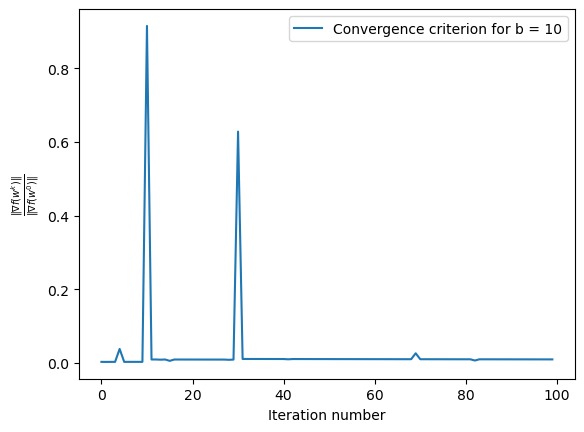

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
b = 10
x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

In [58]:
w_opt

array([0.04061591, 0.01333684, 0.0100442 , 0.01872909, 0.00965721,
       0.08775846, 0.02617908, 0.0099125 ])

For b = 10, I observe that it took 462 seconds and the convergence is quite noisy

(2 pts) Vary the batch size: $b = 1, 10, 100, 1000$, and take the step size equal to $\gamma_k \equiv \frac{1}{L}$. Draw the convergence plot: the value of the convergence criterion from the iteration number for each $b$. Does this plot reflect a fair comparison? Why? Figure out how to compare the results to each other more honestly and draw a new comparison plot. Make a conclusion.

For b = 1


  3%|██▍                                                                             | 3/100 [02:56<1:35:14, 58.92s/it]


My Stochastic Gradient Descent implementation for batchsize 1, took 179.5698893070221 seconds


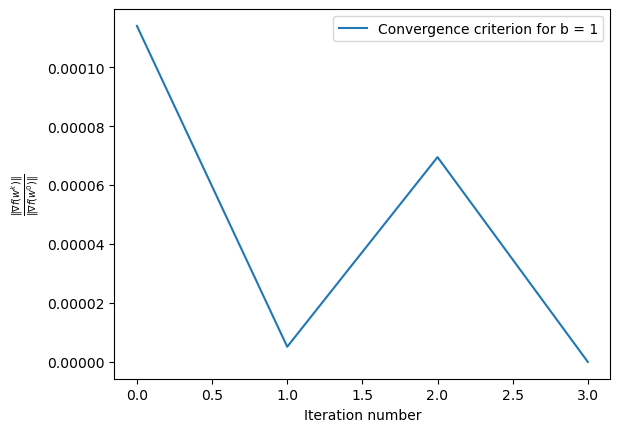

In [59]:
#your code
b = 1
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = 1/L_j(split_x_y((split_data(b, shuffle = True)[0]))[0]),
                              b = b,
                              K = 100, eps = 1e-6, tune_step = False)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For b = 100


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]

My Stochastic Gradient Descent implementation for batchsize 100, took 159.29393529891968 seconds


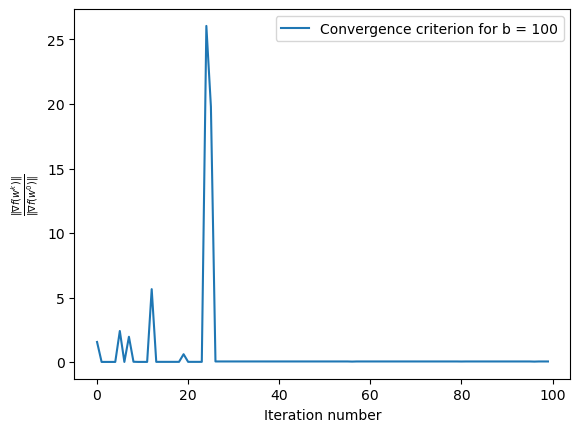

In [60]:
b = 100
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = 1/L_j(split_x_y((split_data(b, shuffle = True)[0]))[0]),
                              b = b,
                              K = 100, eps = 1e-6, tune_step = False)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For b = 1000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]

My Stochastic Gradient Descent implementation for batchsize 1000, took 104.0648558139801 seconds


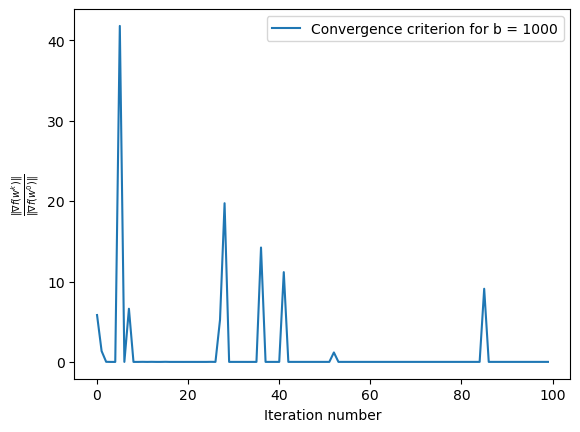

In [61]:
b = 1000
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = 1/L_j(split_x_y((split_data(b, shuffle = True)[0]))[0]),
                              b = b,
                              K = 100, eps = 1e-6, tune_step = False)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

### Observations

I used same start point, $w_0$ and same number of iterations. None of the algorithms stopped early due to convergence criterion.
\
For smaller values of b, the time for the algorithm takes a lot of time.
\
b   : time\
1   : 3712.80699133873 seconds\
10  : 462.2945170402527 seconds\
100 : 137.53938961029053 seconds\
1000: 100.50520586967468 seconds\
\
Also, error range seems to increase with increase in batchsize with b = 1000 the exception.
\
b   : Error Margin\
1   : 0-30\
10  : 0-400\
100 : 0-3000\
1000: 0-30\
\
This suggests that there might be a sweet spot for batchsize which reduces time of algorithm runtime and reduces the noise in convergence.
\
Also, there is high variance in the convergence criterion. This might not be a good comparison because I used same number of iterations, K = 100, irrespective of batchsize and also, because the learning rate depended on the batch size and was quite random.

In [62]:
# Fix Learning rate
gamma_k = 1/L_j(split_x_y((split_data(len(data), shuffle = False)[0]))[0])

For b = 1


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:14:19<00:00, 44.60s/it]


My Stochastic Gradient Descent implementation for batchsize 1, took 4461.909457445145 seconds


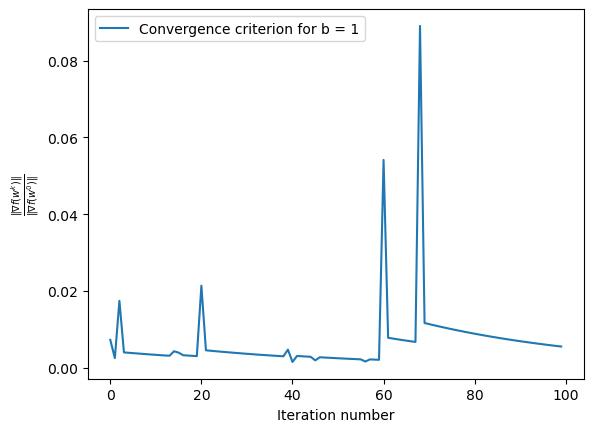

In [63]:
b = 1
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = gamma_k,
                              b = b,
                              K = 100, eps = 1e-6, tune_step = False)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For b = 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:08<00:00,  6.08s/it]

My Stochastic Gradient Descent implementation for batchsize 10, took 609.1054623126984 seconds


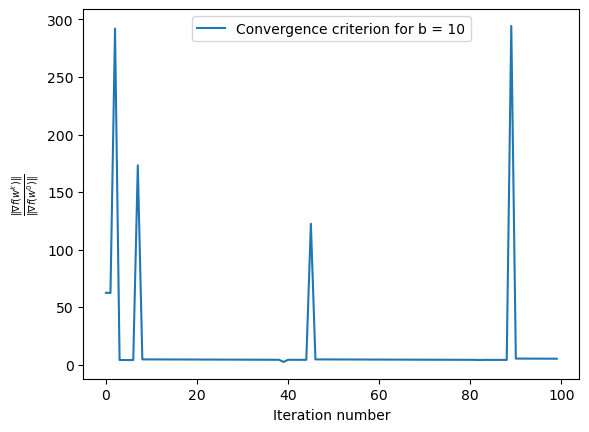

In [64]:
b = 10
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = gamma_k,
                              b = b,
                              K = 100, eps = 1e-6, tune_step = False)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For b = 100


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.68s/it]

My Stochastic Gradient Descent implementation for batchsize 100, took 168.1438434123993 seconds


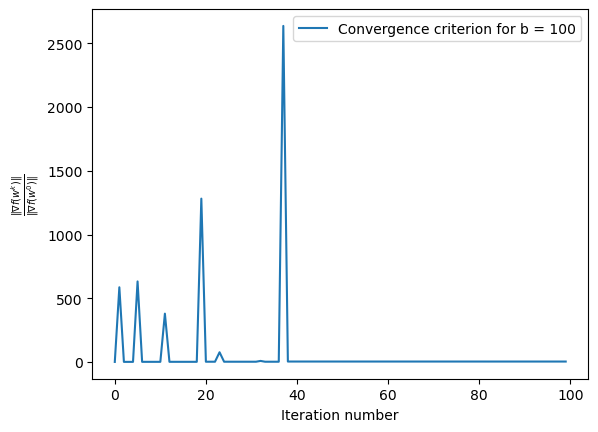

In [65]:
b = 100
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = gamma_k,
                              b = b,
                              K = 100, eps = 1e-6, tune_step = False)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For b = 1000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.67s/it]

My Stochastic Gradient Descent implementation for batchsize 1000, took 166.72481322288513 seconds


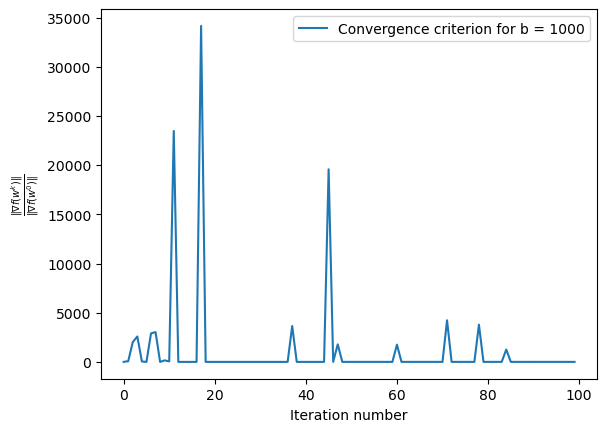

In [66]:
b = 1000
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = gamma_k,
                              b = b,
                              K = 100, eps = 1e-6, tune_step = False)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

(2 pts) Let us fix $b = 10$ and try to change the strategy of choosing the step:

1) $\gamma_k \equiv \frac{1}{L}$ as we did before,

2) $\gamma_k = \frac{1}{\sqrt{k + 1}}$,

3) $\gamma_k = \frac{1}{k + 1}$.

Draw the convergence plot: the value of the convergence criterion from the iteration number. Make a conclusion.

For b = 10


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:36<00:00,  5.77s/it]


My Stochastic Gradient Descent implementation for batchsize 10, took 576.7600793838501 seconds


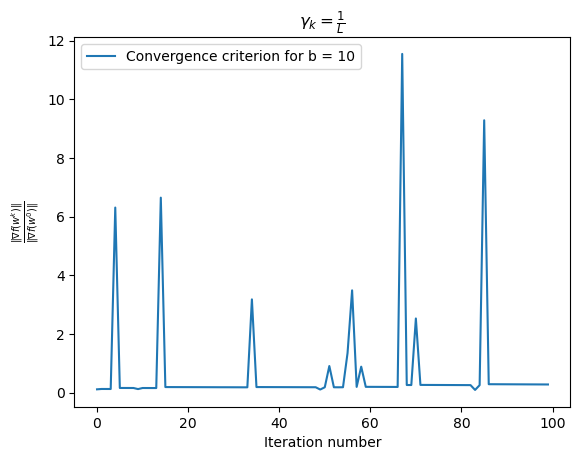

In [67]:
#your code
b = 10
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = lambda k: gamma_k,
                              b = b,
                              K = 100, eps = 1e-6, tune_step = True)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.title('$\\gamma_k = \\frac{1}{L}$')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For b = 10


  0%|                                                                                          | 0/100 [00:05<?, ?it/s]

My Stochastic Gradient Descent implementation for batchsize 10, took 5.775474786758423 seconds


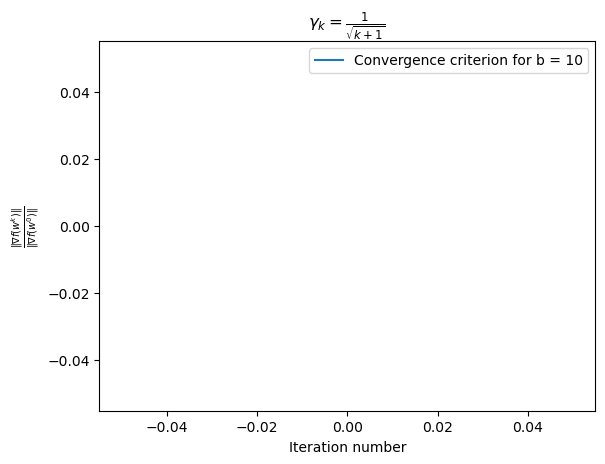

In [68]:
b = 10
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = lambda k: 1/np.sqrt(k+1),
                              b = b,
                              K = 100, eps = 1e-6, tune_step = True)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.title('$\\gamma_k = \\frac{1}{\\sqrt{k+1}}$')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For b = 10


  0%|                                                                                          | 0/100 [00:05<?, ?it/s]


My Stochastic Gradient Descent implementation for batchsize 10, took 5.673852443695068 seconds


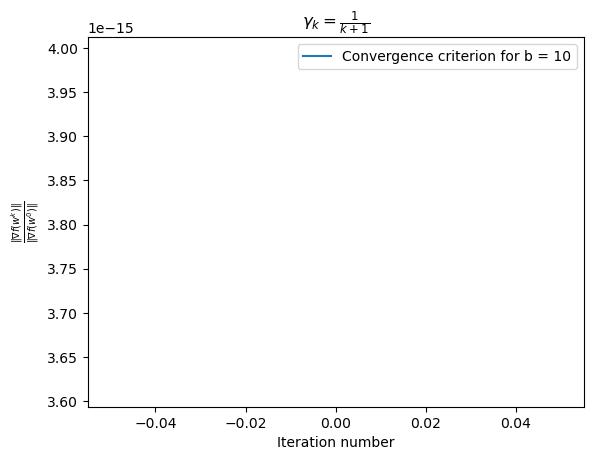

In [69]:
b = 10
print(f'For b = {b}')
w_opt, err = stochastic_gradient_descent(nabla_f = lambda w, x, y: gradient(w, x, y),
                              w_0 = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                              gamma_k = lambda k: 1/(k+1),
                              b = b,
                              K = 100, eps = 1e-6, tune_step = True)

x_cord = [i for i in range(len(err))]
plt.plot(x_cord, err, label = f'Convergence criterion for b = {b}')
plt.title('$\\gamma_k = \\frac{1}{k+1}$')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

(1 pts) Look at the accuracy of the model trained with SGD. Repeat point d)-e), but now plot the accuracy dependence, not the convergence criterion. Make a conclusion.

In [70]:
#your code
